#### Архипов Артем, telegram: @artiomsa

#### Task: Binary classification
#### Key words: Class disbalance, Catboost

In [106]:
import pandas as pd
from functools import reduce
import numpy as np
from scipy.stats import *

In [17]:
def ROC_Curve(X_validation, y_validation, cat_features, model):
    from catboost.utils import get_roc_curve
    import sklearn
    from sklearn import metrics
    import matplotlib.pyplot as plt
    from catboost import Pool

    eval_pool = Pool(X_validation, y_validation, cat_features=cat_features)
    curve = get_roc_curve(model, eval_pool)
    (fpr, tpr, thresholds) = curve
    roc_auc = sklearn.metrics.auc(fpr, tpr)

    plt.figure(figsize=(8, 4))
    lw = 2

    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True)
    plt.xlabel('False Positive Rate', fontsize=10)
    plt.ylabel('True Positive Rate', fontsize=10)
    plt.title('Receiver operating characteristic', fontsize=12)
    plt.legend(loc="lower right", fontsize=10)
    plt.show()
    return curve

In [18]:
def FPR_FNR_Curve(curve):
    import matplotlib.pyplot as plt
    from catboost.utils import get_fpr_curve
    from catboost.utils import get_fnr_curve

    (thresholds, fpr) = get_fpr_curve(curve=curve)
    (thresholds, fnr) = get_fnr_curve(curve=curve) 
    
    plt.figure(figsize=(8, 4))
    lw = 2

    plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
    plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True)
    plt.xlabel('Threshold', fontsize=10)
    plt.ylabel('Error Rate', fontsize=10)
    plt.title('FPR-FNR curves', fontsize=12)
    plt.legend(loc="lower left", fontsize=10)
    plt.show()

In [59]:
def GetThresholds(FPR, FNR, model, X, y, cat_features):
    
    from catboost.utils import select_threshold
    from catboost import Pool
    
    eval_pool = Pool(X, y, cat_features=cat_features)
    
    print('FNR threshold', select_threshold(model=model, data=eval_pool, FNR=FNR))
    print('FPR threshold', select_threshold(model=model, data=eval_pool, FPR=FPR))

In [375]:
url_train = 'https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-train.csv'
url_test = 'https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-test.csv'
url_desc = 'https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-desc.csv'

In [376]:
train_df = pd.read_csv(url_train, sep = ';')
test_df = pd.read_csv(url_test, sep = ';')
description_df = pd.read_csv(url_desc, sep = ';')

# Data Observing

In [4]:
train_df.head()

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,...,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,default_12m
0,7,52996000.0,48344000.0,48344000.0,0.0,0.0,4652000.0,-2608000.0,2044000.0,846000.0,...,3,3,3,[1-100],50000.0,2,0,0,0,0
1,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12,12,12,[1-100],10000.0,5,0,0,0,0
2,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28,28,28,[1-100],10000.0,2,0,0,0,0
3,22,32049000.0,29568000.0,29568000.0,0.0,0.0,2481000.0,-260000.0,2221000.0,302000.0,...,8,8,8,[1-100],300000.0,1,0,0,0,0
4,23,16458000.0,14935000.0,14935000.0,0.0,0.0,1523000.0,-274000.0,1249000.0,538000.0,...,27,27,27,[1-100],10000.0,2,0,0,0,0


In [5]:
print('train',train_df.shape)
print('test',test_df.shape)

train (32395, 37)
test (200, 36)


#### Описание признаков

In [6]:
description_df

,field,desc_eng,desc_rus
0,ar_revenue,Sales revenue (at the end of the last year),Выручка от реализации (на конец последнего года)
1,ar_total_expenses,Total expenses for the last year,Общие расходы за последний год
2,ar_sale_cost,Cost of sales (at the end of the last year),Себестоимость продаж (на конец последнего года)
3,ar_selling_expenses,Selling expenses (at the end of the last year),Коммерческие расходы (на конец последнего года)
4,ar_management_expenses,Administrative expenses (at the end of the las...,Управленческие расходы (на конец последнего года)
5,ar_sale_profit,Profit from sales (at the end of the last year),Прибыль от реализации (на конец последнего года)
6,ar_balance_of_rvns_and_expns,Balance of income and expenses (at the end of ...,Баланс доходов и расходов (на конец последнего...
7,ar_profit_before_tax,Gross Profit (end of last year),Валовая прибыль (на конец последнего года)
8,ar_taxes,Current income tax (at the end of the last year),Текущий на налог на прибыль (на конец последне...
9,ar_other_profit_and_losses,Other income and expenses (at the end of the l...,Прочие доходы и расходы (на конец последнего г...


### Target (default_12m)

#### Наблюдается сильный перекос классов, что делает метрику Accuracy малоинформативной для валидации

In [7]:
print('0 class:',round(train_df[train_df.default_12m == 0].shape[0] / train_df.shape[0] * 100), '%')
print('1 class:',round(train_df[train_df.default_12m == 1].shape[0] / train_df.shape[0] * 100), '%')
train_df.groupby('default_12m').agg({'record_id':'count'})

0 class: 94 %
1 class: 6 %


,record_id
default_12m,
0,30304
1,2091


### Nan-values

In [8]:
train_df.isna().sum()

record_id                           0
ar_revenue                      15145
ar_total_expenses               15145
ar_sale_cost                    15145
ar_selling_expenses             15145
ar_management_expenses          15145
ar_sale_profit                  15145
ar_balance_of_rvns_and_expns    15145
ar_profit_before_tax            15145
ar_taxes                        15145
ar_other_profit_and_losses      15145
ar_net_profit                   15145
ab_immobilized_assets           15145
ab_mobile_current_assets        15145
ab_inventory                    15145
ab_accounts_receivable          15145
ab_other_current_assets         15145
ab_cash_and_securities          15145
ab_losses                       15145
ab_own_capital                  15145
ab_borrowed_capital             15145
ab_long_term_liabilities        15145
ab_short_term_borrowing         15145
ab_accounts_payable             15145
ab_other_borrowings             15145
bus_age                             0
ogrn_age    

In [9]:
nan_vals = dict(train_df.isna().sum())
nan_features = []
for i in nan_vals.keys():
    if nan_vals[i] > 0:
        nan_features.append(i)

In [10]:
print('признаков с Nan:',len(nan_features), nan_features[:5])

признаков с Nan: 24 ['ar_revenue', 'ar_total_expenses', 'ar_sale_cost', 'ar_selling_expenses', 'ar_management_expenses']


#### Заметим, что кол-во пустых значений одинаковое. Посмотрим, на пересечение наборов индексов с пустыми значениями (т.е. посмотрим, действительно ли, если убрать 15145 строк из train_df, то будут убраны абсолютно все пустые значения в train_df)

In [11]:
for feature in nan_features:
    feature_ind = list(train_df[train_df[feature].notna()].index)
    for oth_feature in nan_features:
        oth_feature_ind = list(train_df[train_df[oth_feature].notna()].index)
        if reduce(lambda x, y : x and y, map(lambda p, q: p == q,feature_ind,oth_feature_ind), True): 
            pass
        else: 
            print ("Not the same Nan indexes")

In [12]:
# тут до меня дошло, что можно было сделать проще, а именно
train_df.shape[0] - train_df.dropna().shape[0] == 15145

True

#### Значит пустые значения признаков встречаются только в 15145 строках и при этом во всех 24 признаках (из nan_features)

### !!Очень много объектов 1-го класса имеют пустые значения. Это координально усложняет задачу

In [168]:
print('Объектов 1-го класса',train_df[train_df.default_12m == 1].shape[0])
print('Из них НЕ с пустыми значениями',train_df[train_df.default_12m == 1].dropna().shape[0])

Объектов 1-го класса 2091
Из них НЕ с пустыми значениями 796


### Types of Features (categorial, numeric)

In [13]:
train_df.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

#### Все признаки выражены численными типами данных int64 и float64. Всего один признак типа object

In [14]:
train_df.select_dtypes(include=['O']).head(1)

,ul_staff_range
0,[1-100]


#### Посмотрим на описание признаков и кол-во уникальных значений, чтобы выделить категориальные и числовые признаки

In [15]:
description_df.merge(
pd.DataFrame(train_df.nunique().sort_values())\
.reset_index().rename(columns = {'index':'field', 0:'count_unique_vals'}), on = 'field'
).sort_values('count_unique_vals').drop('desc_eng', axis = 1)

,field,desc_rus,count_unique_vals
34,ul_systematizing_flg,Системообразующая компания,1
33,ul_strategic_flg,Компания стратегического значения,2
29,ul_staff_range,Количество сотрудников,3
32,ul_branch_cnt,Количество филиалов,13
26,adr_actual_age,Срок с момента регистрации юридического адреса,33
27,head_actual_age,Срок с момента назначения руководителя,33
28,cap_actual_age,Срок с момента установки капитала,33
25,ogrn_age,Срок с момента присваивания ОГРН,150
31,ul_founders_cnt,Количество акционеров,278
24,bus_age,Срок ведения бизнеса,315


In [16]:
print('uniques for ul_systematizing_flg:', train_df.ul_systematizing_flg.unique())
print('uniques for ul_strategic_flg:', train_df.ul_strategic_flg.unique())
print('uniques for ul_staff_range:', train_df.ul_staff_range.unique())

uniques for ul_systematizing_flg: [0]
uniques for ul_strategic_flg: [0 1]
uniques for ul_staff_range: ['[1-100]' '(100-500]' '> 500']


#### Проанализировав описание признаков и количество уникальных значений этих признаков было выделено:


#### 1. Все имющиеся признаки (кроме ul_systematizing_flg, ul_strategic_flg, ul_staff_range) можно отнести к численным (не категориальным) с точки зрения того, логически верно ли применять к ним алгебро-логические операции (операторы >, <, =) для выполнения сплитов в будущей ml молеи

#### 2. ul_systematizing_flg(Системообразующая компания) имеет единственное уникальное значение, соответственно этот признак не является информативным для молели ml, при обучении его нужно отбросить

#### 3. ul_strategic_flg(Компания стратегического значения) хоть и задается численными занчениями 0 и 1, но по сути своей не явяется численным признаком и применять алгебраические операции к нему не совсем верно. Поэтому, при обучении бустинга Catboost в частности, в будущем - этот признак будет добавлен мной в набор категориальных признаков

#### 4. ul_staff_range(Количество сотрудников) имеет уникальные значения ['[1-100]', '(100-500]', '> 500'] типа object в pandas.DataFrame, однако по сути своей признак численный. Для него уникальные значения будут преобразованы в численные, с сохранением семантики признака. Предлагаю следующие замены: '[1-100]' -> 1;         '(100-500]' -> 2;        '> 500'->3

# Baseline model

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import *
from catboost import *
from catboost import CatBoostClassifier

#### Бейзлайн построим без учетом заключений выше и предложенных выше вариантов замен

#### Для решения задачи используем градиентный бустинг на деревьях решений CatBoost, в частности CatBoostClassifier

#### Почему градиентный бустинг? Потому что это лучший вариант для использования на разнородных данных

In [44]:
baseline_df = train_df.copy()
baseline_df = baseline_df.dropna()
baseline_df.ul_staff_range = baseline_df.ul_staff_range.map({'[1-100]':1, '(100-500]':2, '> 500':3})

X_train_base, X_validation_base, y_train_base, y_validation_base =\
train_test_split(baseline_df.drop('default_12m', axis = 1), baseline_df.default_12m,\
                 train_size=0.8, random_state=23)

X_validation_base, X_test, y_validation_base, y_test =\
train_test_split(X_validation_base, y_validation_base,\
                 train_size=0.5, random_state=2)

In [31]:
baseline_model = CatBoostClassifier(custom_loss=['Accuracy','AUC'], eval_metric='AUC')

In [32]:
baseline_model.fit(X_train_base,
    y_train_base,
    use_best_model=True,
    eval_set=(X_validation_base, y_validation_base),
    verbose=False,
    plot=True,
    early_stopping_rounds=500)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [33]:
baseline_model.tree_count_

299

In [35]:
features_imp_df = pd.DataFrame()
features_imp_df['feature'] = X_train_base.columns
features_imp_df['importance_val'] = baseline_model.feature_importances_
features_imp_df.sort_values('importance_val',ascending=False)

,feature,importance_val
19,ab_own_capital,6.068319
17,ab_cash_and_securities,5.924302
25,bus_age,5.013708
22,ab_short_term_borrowing,4.888254
26,ogrn_age,4.299133
23,ab_accounts_payable,4.013877
7,ar_balance_of_rvns_and_expns,3.744280
9,ar_taxes,3.732684
15,ab_accounts_receivable,3.650563
14,ab_inventory,3.574265


#### Как видим, бейзлайн модель демонстрирует качество немногим (я бы сказал "совсем не") лучшее чем константное предсказание "0" класса

In [226]:
print('В тесте класса 0:',y_test.shape[0] - y_test.sum(), 'класса 1:', y_test.sum())
print('Соотношение:', round(y_test.sum() / y_test.shape[0] * 100,2), '% класса 1' )

В тесте класса 0: 1650 класса 1: 75
Соотношение: 4.35 % класса 1


In [46]:
f1_score(y_test, baseline_model.predict(X_test))

0.02631578947368421

In [47]:
precision_score(y_test, baseline_model.predict(X_test)) 
# среди классифиципованных как "объект 1 класса" - 100% действительно объекты 1 класса

1.0

In [48]:
recall_score(y_test, baseline_model.predict(X_test))
# Однако, среди всех объектов 1 класса - мы "нашли"  всего 1%

0.013333333333333334

#### В данном случае, нам гораздо важнее правильно находить объекты первого класса, тк лучше ошибиться в классе 0, чем пропустить компанию-банкрота

In [49]:
accuracy_score(y_test, baseline_model.predict(X_test))

0.9571014492753623

In [50]:
(y_test == 0).sum() / y_test.shape[0]

0.9565217391304348

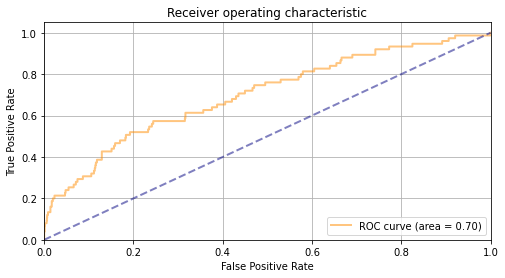

In [52]:
baseline_curve = ROC_Curve(X_test, y_test, [], baseline_model)

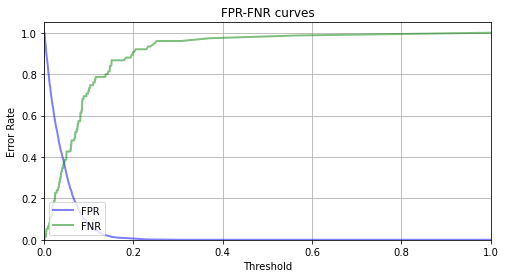

In [53]:
FPR_FNR_Curve(baseline_curve)

#### Посмотрим на границу принятия решений при желаемом значении FNR=0.05, например

#### Как видим, при  желаемом FNR = 0.05 (ошибаемся лишь на 5% объектов 1 класса) имеем FPR = 0.6 (то есть при этом будем ошибаться в 60% объектов класса 0, что интуитивно - очень много)

In [85]:
GetThresholds(FPR = 0.6, FNR = 0.05, model=baseline_model, X=X_validation_base, y=y_validation_base, cat_features=[])

FNR threshold 0.02133910224834039
FPR threshold 0.021811346189773935


#### Предлагаю: Требуемое значение Recall выставить на уровне 0.95 (FNR при этом будет равен 0.05), а значение Precission (FPR) при этом будем оптимизировать

# Data post-preparation

In [86]:
def GetDistrib(df, column):
    df.groupby(column).agg({'record_id':'count'}).reset_index().plot(x = column, y = 'record_id')

In [87]:
new_train_df = train_df.copy()

#### Заменим занчения в поле ul_staff_range (Количество сторудников) следующим образом: '[1-100]' -> 1;         '(100-500]' -> 2;        '> 500'->3

In [88]:
dict_for_ul_staff_range = {'[1-100]':1, '(100-500]':2, '> 500':3}

In [89]:
new_train_df['ul_staff_range'] = new_train_df['ul_staff_range'].map(dict_for_ul_staff_range)

#### Отбросим константный признак (у которого 1 уникальное значение)

In [90]:
new_train_df = new_train_df.drop('ul_systematizing_flg', axis = 1)

#### В классах наблюдется сильный перекос. Предлагается использовать методы по увеличению числа примеров миноритарного класса (попробуем ADASYN), SMOTE тоже был протестирован, но лучший результат дал ADASYN

In [91]:
from imblearn.over_sampling import ADASYN

In [92]:
ada = ADASYN(random_state=23)

#### ADASYN не дает использовать больше 15 признаков, поэтому тут я отбираю 15 наиболее полезных по baseline-модели

In [94]:
X_ada, y_ada = ada.fit_resample(new_train_df.dropna()[list(features_imp_df.sort_values('importance_val',ascending=False).head(15).feature)], new_train_df.dropna().default_12m)


X_train_ada, X_validation_ada, y_train_ada, y_validation_ada =\
    train_test_split(X_ada, y_ada, train_size=0.8, random_state=23)

#### Также заполним пропуски средними внутриклассовыми значениями признаков, проведем однофакторный дисперсионный анализ и отберем наиболее информативные признаки

In [102]:
mean_train_df = new_train_df.copy()

In [103]:
for column in mean_train_df.columns:
    mean_train_df.loc[(mean_train_df.default_12m == 1) & (mean_train_df[column].isna()), column] = \
    mean_train_df[mean_train_df.default_12m == 1][column].mean()    
    mean_train_df.loc[(mean_train_df.default_12m == 0) & (mean_train_df[column].isna()), column] = \
    mean_train_df[mean_train_df.default_12m == 0][column].mean()

#### Проведем однофакторный ANOVA

In [126]:
pvalues = []
for column in mean_train_df.columns:
    pvalues.append(kruskal(list(mean_train_df[mean_train_df.default_12m == 0][column]),\
                           list(mean_train_df[mean_train_df.default_12m == 1][column]))[1])

In [131]:
kruskal_res = pd.DataFrame()
kruskal_res['column'] = mean_train_df.columns
kruskal_res['pvalue'] = pvalues

In [138]:
kruskal_res.sort_values('pvalue').head()

,column,pvalue
35,default_12m,0.000000e+00
8,ar_profit_before_tax,5.665297e-307
11,ar_net_profit,6.456726e-290
18,ab_losses,1.891910e-289
19,ab_own_capital,5.314646e-285


In [143]:
kruskal_columns = list(kruskal_res.sort_values('pvalue').column[:16])

In [145]:
kruskal_and_mean_train_df = mean_train_df.copy()
kruskal_and_mean_train_df = kruskal_and_mean_train_df[kruskal_columns]

In [146]:
kruskal_and_mean_train_df.head()

,default_12m,ar_profit_before_tax,ar_net_profit,ab_losses,ab_own_capital,ar_sale_profit,ar_taxes,ar_revenue,ar_sale_cost,ar_total_expenses,ab_mobile_current_assets,ab_cash_and_securities,ab_inventory,ab_borrowed_capital,ab_accounts_receivable,ab_accounts_payable
0,0,2.044000e+06,1.198000e+06,1.198000e+06,6.630000e+05,4.652000e+06,846000.000000,5.299600e+07,4.834400e+07,4.834400e+07,7.240000e+06,2.550000e+05,4.988000e+06,1.587200e+07,2.252000e+06,4.523000e+06
1,0,4.252215e+06,3.858921e+06,3.417727e+06,1.973790e+07,4.901846e+06,433912.883068,8.319980e+07,7.464469e+07,7.829795e+07,3.103936e+07,1.652003e+06,1.661353e+07,2.451933e+07,1.359942e+07,1.530062e+07
2,0,4.252215e+06,3.858921e+06,3.417727e+06,1.973790e+07,4.901846e+06,433912.883068,8.319980e+07,7.464469e+07,7.829795e+07,3.103936e+07,1.652003e+06,1.661353e+07,2.451933e+07,1.359942e+07,1.530062e+07
3,0,2.221000e+06,1.919000e+06,1.919000e+06,2.219000e+06,2.481000e+06,302000.000000,3.204900e+07,2.956800e+07,2.956800e+07,4.245000e+06,2.500000e+04,4.082000e+06,3.652000e+06,1.630000e+05,0.000000e+00
4,0,1.249000e+06,7.110000e+05,7.110000e+05,1.243900e+07,1.523000e+06,538000.000000,1.645800e+07,1.493500e+07,1.493500e+07,8.950000e+06,4.920000e+05,8.606000e+06,1.279000e+06,3.440000e+05,1.279000e+06


#### Накатим ADASYN на заполненный средними значениями датасет (ограничимся 15-ю признаками)

In [147]:
X_ada_means, y_ada_means = ada.fit_resample(kruskal_and_mean_train_df.drop('default_12m', axis = 1), \
                                            kruskal_and_mean_train_df.default_12m)

X_train_ada_means, X_validation_ada_means, y_train_ada_means, y_validation_ada_means =\
    train_test_split(X_ada_means, y_ada_means, train_size=0.8, random_state=23)

#### Наконец сделаем еще один "маленький" датасет, в котором будут все объекты 1 класса и некоторые (случайно выбранные) объекты 0 класса. Соотношение классов 1:1

In [176]:
small_df = new_train_df.copy()

In [177]:
small_df_ones = small_df[small_df.default_12m == 1]
small_df_zeros = small_df[small_df.default_12m == 0].dropna().head(small_df_ones.shape[0])
small_df = pd.concat([small_df_ones, small_df_zeros])

#### Заполняем пропуски только в 1 классе, тк объектов 0 класса без пропусков - итак в избытке

In [178]:
for column in small_df.columns:
    small_df.loc[(small_df.default_12m == 1) & (small_df[column].isna()), column] = \
    small_df[small_df.default_12m == 1][column].mean()    

In [180]:
small_df.head()

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,...,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,default_12m
25,188.0,4.475500e+07,4.266500e+07,4.266500e+07,0.000000e+00,0.000000,2.090000e+06,-405000.000000,1.685000e+06,2000.000000,...,142.0,1.0,1.0,1.0,1.0,10000.0,1.0,0.0,0,1
30,213.0,2.317900e+07,2.206400e+07,2.206400e+07,0.000000e+00,0.000000,1.115000e+06,115000.000000,1.230000e+06,265000.000000,...,36.0,23.0,23.0,23.0,1.0,10000.0,1.0,0.0,0,1
77,578.0,4.718194e+07,4.550537e+07,4.340810e+07,1.353368e+06,743900.753769,1.676565e+06,-494600.502513,1.181965e+06,106557.788945,...,10.0,9.0,9.0,9.0,1.0,10000.0,1.0,0.0,0,1
97,743.0,4.718194e+07,4.550537e+07,4.340810e+07,1.353368e+06,743900.753769,1.676565e+06,-494600.502513,1.181965e+06,106557.788945,...,37.0,6.0,6.0,6.0,1.0,10000.0,1.0,0.0,0,1
111,815.0,7.190000e+06,6.857000e+06,6.857000e+06,0.000000e+00,0.000000,3.330000e+05,0.000000,3.330000e+05,0.000000,...,39.0,2.0,2.0,2.0,1.0,11000.0,1.0,0.0,0,1


In [181]:
small_df.shape

(4182, 36)

# Model Training

#### Итак имеем 6 наборов данных, это:
#### 1. "Практически" данные (new_train_df)
#### 2. Данные new_train_df с использованием ADASYN-алгоритма восполнения минотирующего класса (15 признаков) (X_ada, y_ada)
#### 3. Данные с заполненными средними занчениями пропусками (mean_train_df)
#### 4. Данные с заполненными средними занчениями пропусками (15 признаков из ANOVA) (kruskal_and_mean_train_df)
#### 5. Данные с заполненными средними занчениями пропусками (15 признаков из ANOVA) + ADASYN (X_ada_means, y_ada_means)
#### 6. Данные с заполненными средними занчениями пропусками (только 1 класс) + без дисбаланса классов (small_df)

In [294]:
from catboost import cv

# params = {}
# params['loss_function'] = 'Logloss'
# params['iterations'] = 10000
# params['custom_loss'] = ['AUC', 'Accuracy']
# params['random_seed'] = 23
# params['learning_rate'] = 0.01

# cv_data = cv(
#     params = params,
#     pool = Pool(X_train_ada, label=y_train_ada),
#     fold_count=5,
#     shuffle=True,
#     partition_random_seed=0,
#     plot=True,
#     stratified=True,
#     verbose=False
# )

#### Обучим на всех наборах 2 модели. model1 и model2

### Fitting model1 (автоматические параметры)

In [189]:
model1 = CatBoostClassifier(custom_loss=['AUC', 'Accuracy'], eval_metric='AUC')

In [215]:
metric = ['DataFrame','Precision', 'Recall', 'AUC', 'F1', 'Accuracy']
model1_metrics_df = pd.DataFrame(columns = metric)

In [216]:
#### 1. "Практически" данные (new_train_df)
X_train_new, X_validation_new, y_train_new, y_validation_new =\
    train_test_split(new_train_df.drop('default_12m', axis = 1), \
                     new_train_df.default_12m, train_size=0.8, random_state=23)


model1.fit(X_train_new,
    y_train_new,
    cat_features=[30, 34], # признаки ul_staff_range и ul_strategic_flg
    use_best_model=True,
    eval_set=(X_validation_new, y_validation_new),
    verbose=False,
    plot=False,
    early_stopping_rounds=1000)


model1_metrics_df = model1_metrics_df.append({'DataFrame':'new_train_df',\
                          'Precision':precision_score(model1.predict(X_test), y_test),\
                          'Recall':recall_score(model1.predict(X_test), y_test),\
                          'AUC':roc_auc_score(model1.predict(X_test), y_test),\
                          'F1':f1_score(model1.predict(X_test), y_test),\
                          'Accuracy':accuracy_score(model1.predict(X_test), y_test)},\
                         ignore_index=True)

In [217]:
#### 2. Данные new_train_df с использованием ADASYN-алгоритма 
#### восполнения минотирующего класса (15 признаков) (X_ada, y_ada)

model1.fit(X_train_ada,
    y_train_ada,
    use_best_model=True,
    eval_set=(X_validation_ada, y_validation_ada),
    verbose=False,
    plot=False,
    early_stopping_rounds=1000)


model1_metrics_df = model1_metrics_df.append({'DataFrame':'new_df with ADASYN',\
                          'Precision':precision_score(model1.predict(X_test), y_test),\
                          'Recall':recall_score(model1.predict(X_test), y_test),\
                          'AUC':roc_auc_score(model1.predict(X_test), y_test),\
                          'F1':f1_score(model1.predict(X_test), y_test),\
                          'Accuracy':accuracy_score(model1.predict(X_test), y_test)},\
                         ignore_index=True)

In [219]:
#### 3. Данные с заполненными средними занчениями пропусками (mean_train_df)

X_train_means, X_validation_means, y_train_means, y_validation_means =\
    train_test_split(mean_train_df.drop('default_12m', axis = 1), \
                     mean_train_df.default_12m, train_size=0.8, random_state=23)

model1.fit(X_train_means,
    y_train_means,
    use_best_model=True,
    eval_set=(X_validation_means, y_validation_means),
    verbose=False,
    plot=False,
    early_stopping_rounds=1000)


model1_metrics_df = model1_metrics_df.append({'DataFrame':'mean_train_df',\
                          'Precision':precision_score(model1.predict(X_test), y_test),\
                          'Recall':recall_score(model1.predict(X_test), y_test),\
                          'AUC':roc_auc_score(model1.predict(X_test), y_test),\
                          'F1':f1_score(model1.predict(X_test), y_test),\
                          'Accuracy':accuracy_score(model1.predict(X_test), y_test)},\
                         ignore_index=True)

In [227]:
#### 4. Данные с заполненными средними занчениями пропусками (15 признаков из ANOVA) (kruskal_and_mean_train_df)

X_train_kruskal_and_mean, X_validation_kruskal_and_mean, y_train_kruskal_and_mean, y_validation_kruskal_and_mean =\
    train_test_split(kruskal_and_mean_train_df.drop('default_12m', axis = 1), \
                     kruskal_and_mean_train_df.default_12m, train_size=0.8, random_state=23)

model1.fit(X_train_kruskal_and_mean,
    y_train_kruskal_and_mean,
    use_best_model=True,
    eval_set=(X_validation_kruskal_and_mean, y_validation_kruskal_and_mean),
    verbose=False,
    plot=False,
    early_stopping_rounds=1000)


model1_metrics_df = model1_metrics_df.append({'DataFrame':'kruskal_and_mean_train_df',\
                          'Precision':precision_score(model1.predict(X_test), y_test),\
                          'Recall':recall_score(model1.predict(X_test), y_test),\
                          'AUC':roc_auc_score(model1.predict(X_test), y_test),\
                          'F1':f1_score(model1.predict(X_test), y_test),\
                          'Accuracy':accuracy_score(model1.predict(X_test), y_test)},\
                         ignore_index=True)

In [231]:
#### 5. Данные с заполненными средними занчениями пропусками (15 признаков из ANOVA) +
#### ADASYN (X_ada_means, y_ada_means)

X_train_ada_means, X_validation_ada_means, y_train_ada_means, y_validation_ada_means =\
    train_test_split(X_ada_means, \
                     y_ada_means, train_size=0.8, random_state=23)

model1.fit(X_train_ada_means,
    y_train_ada_means,
    use_best_model=True,
    eval_set=(X_validation_ada_means, y_validation_ada_means),
    verbose=False,
    plot=False,
    early_stopping_rounds=1000)


model1_metrics_df = model1_metrics_df.append({'DataFrame':'ADASYN_and_mean_df',\
                          'Precision':precision_score(model1.predict(X_test), y_test),\
                          'Recall':recall_score(model1.predict(X_test), y_test),\
                          'AUC':roc_auc_score(model1.predict(X_test), y_test),\
                          'F1':f1_score(model1.predict(X_test), y_test),\
                          'Accuracy':accuracy_score(model1.predict(X_test), y_test)},\
                         ignore_index=True)

In [233]:
#### 6. Данные с заполненными средними занчениями пропусками (только 1 класс) + без дисбаланса классов (small_df)

X_train_small, X_validation_small, y_train_small, y_validation_small =\
    train_test_split(small_df.drop('default_12m', axis = 1), \
                     small_df.default_12m, train_size=0.8, random_state=23)

model1.fit(X_train_small,
    y_train_small,
    use_best_model=True,
    eval_set=(X_validation_small, y_validation_small),
    verbose=False,
    plot=False,
    early_stopping_rounds=1000)


model1_metrics_df = model1_metrics_df.append({'DataFrame':'small_df_no_disbalance',\
                          'Precision':precision_score(model1.predict(X_test), y_test),\
                          'Recall':recall_score(model1.predict(X_test), y_test),\
                          'AUC':roc_auc_score(model1.predict(X_test), y_test),\
                          'F1':f1_score(model1.predict(X_test), y_test),\
                          'Accuracy':accuracy_score(model1.predict(X_test), y_test)},\
                         ignore_index=True)

In [234]:
model1_metrics_df

,DataFrame,Precision,Recall,AUC,F1,Accuracy
0,new_train_df,0.053333,1.000000,0.979372,0.101266,0.958841
1,new_df with ADASYN,0.773333,0.517857,0.753659,0.620321,0.958841
2,mean_train_df,0.040000,1.000000,0.979094,0.076923,0.958261
3,kruskal_and_mean_train_df,0.040000,1.000000,0.979094,0.076923,0.958261
4,ADASYN_and_mean_df,0.946667,0.312775,0.655053,0.470199,0.907246
5,small_df_no_disbalance,0.906667,0.045063,0.506328,0.085859,0.160580


### Fitting model2 (ручные параметры)

In [237]:
model2 = CatBoostClassifier(iterations=10000,
                         learning_rate=0.01,
                         loss_function='Logloss',
                         use_best_model=True,
                         verbose=False,
                         custom_loss=['AUC', 'Accuracy'],
                         custom_metric=None,
                         eval_metric='AUC',
                         boosting_type=None,
                         bootstrap_type=None,
                         max_depth=None,
                         n_estimators=None,
                         random_state=None,
                         early_stopping_rounds=500,
                         #cat_features=cat_features,
                         )

In [235]:
model2_metrics_df = pd.DataFrame(columns = metric)

In [239]:
#### 1. "Практически" данные (new_train_df)

model2.fit(X_train_new,
    y_train_new,
    cat_features=[30, 34], # признаки ul_staff_range и ul_strategic_flg
    use_best_model=True,
    eval_set=(X_validation_new, y_validation_new),
    verbose=False,
    plot=True,
    early_stopping_rounds=1000)


model2_metrics_df = model2_metrics_df.append({'DataFrame':'new_train_df',\
                          'Precision':precision_score(model2.predict(X_test), y_test),\
                          'Recall':recall_score(model2.predict(X_test), y_test),\
                          'AUC':roc_auc_score(model2.predict(X_test), y_test),\
                          'F1':f1_score(model2.predict(X_test), y_test),\
                          'Accuracy':accuracy_score(model2.predict(X_test), y_test)},\
                         ignore_index=True)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [241]:
#### 2. Данные new_train_df с использованием ADASYN-алгоритма 
#### восполнения минотирующего класса (15 признаков) (X_ada, y_ada)

model2.fit(X_train_ada,
    y_train_ada,
    use_best_model=True,
    eval_set=(X_validation_ada, y_validation_ada),
    verbose=False,
    plot=True,
    early_stopping_rounds=1000)


model2_metrics_df = model2_metrics_df.append({'DataFrame':'new_df with ADASYN',\
                          'Precision':precision_score(model2.predict(X_test), y_test),\
                          'Recall':recall_score(model2.predict(X_test), y_test),\
                          'AUC':roc_auc_score(model2.predict(X_test), y_test),\
                          'F1':f1_score(model2.predict(X_test), y_test),\
                          'Accuracy':accuracy_score(model2.predict(X_test), y_test)},\
                         ignore_index=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [252]:
#### 3. Данные с заполненными средними занчениями пропусками (mean_train_df)


model2.fit(X_train_means,
    y_train_means,
    use_best_model=True,
    eval_set=(X_validation_means, y_validation_means),
    verbose=False,
    plot=True,
    early_stopping_rounds=1000)


model2_metrics_df = model2_metrics_df.append({'DataFrame':'mean_train_df',\
                          'Precision':precision_score(model2.predict(X_test), y_test),\
                          'Recall':recall_score(model2.predict(X_test), y_test),\
                          'AUC':roc_auc_score(model2.predict(X_test), y_test),\
                          'F1':f1_score(model2.predict(X_test), y_test),\
                          'Accuracy':accuracy_score(model2.predict(X_test), y_test)},\
                         ignore_index=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [253]:
#### 4. Данные с заполненными средними занчениями пропусками (15 признаков из ANOVA) (kruskal_and_mean_train_df)



model2.fit(X_train_kruskal_and_mean,
    y_train_kruskal_and_mean,
    use_best_model=True,
    eval_set=(X_validation_kruskal_and_mean, y_validation_kruskal_and_mean),
    verbose=False,
    plot=True,
    early_stopping_rounds=1000)


model2_metrics_df = model2_metrics_df.append({'DataFrame':'kruskal_and_mean_train_df',\
                          'Precision':precision_score(model2.predict(X_test), y_test),\
                          'Recall':recall_score(model2.predict(X_test), y_test),\
                          'AUC':roc_auc_score(model2.predict(X_test), y_test),\
                          'F1':f1_score(model2.predict(X_test), y_test),\
                          'Accuracy':accuracy_score(model2.predict(X_test), y_test)},\
                         ignore_index=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [248]:
#### 5. Данные с заполненными средними занчениями пропусками (15 признаков из ANOVA) +
#### ADASYN (X_ada_means, y_ada_means)

model2.fit(X_train_ada_means,
    y_train_ada_means,
    use_best_model=True,
    eval_set=(X_validation_ada_means, y_validation_ada_means),
    verbose=False,
    plot=True,
    early_stopping_rounds=1000)


model2_metrics_df = model2_metrics_df.append({'DataFrame':'ADASYN_and_mean_df',\
                          'Precision':precision_score(model2.predict(X_test), y_test),\
                          'Recall':recall_score(model2.predict(X_test), y_test),\
                          'AUC':roc_auc_score(model2.predict(X_test), y_test),\
                          'F1':f1_score(model2.predict(X_test), y_test),\
                          'Accuracy':accuracy_score(model2.predict(X_test), y_test)},\
                         ignore_index=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [255]:
#### 6. Данные с заполненными средними занчениями пропусками (только 1 класс) + без дисбаланса классов (small_df)


model2.fit(X_train_small,
    y_train_small,
    use_best_model=True,
    eval_set=(X_validation_small, y_validation_small),
    verbose=False,
    plot=True,
    early_stopping_rounds=5000)


model2_metrics_df = model2_metrics_df.append({'DataFrame':'small_df_no_disbalance',\
                          'Precision':precision_score(model2.predict(X_test), y_test),\
                          'Recall':recall_score(model2.predict(X_test), y_test),\
                          'AUC':roc_auc_score(model2.predict(X_test), y_test),\
                          'F1':f1_score(model2.predict(X_test), y_test),\
                          'Accuracy':accuracy_score(model2.predict(X_test), y_test)},\
                         ignore_index=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Evaluation

In [269]:
model1_metrics_df

,DataFrame,Precision,Recall,AUC,F1,Accuracy
0,new_train_df,0.053333,1.000000,0.979372,0.101266,0.958841
1,new_df with ADASYN,0.773333,0.517857,0.753659,0.620321,0.958841
2,mean_train_df,0.040000,1.000000,0.979094,0.076923,0.958261
3,kruskal_and_mean_train_df,0.040000,1.000000,0.979094,0.076923,0.958261
4,ADASYN_and_mean_df,0.946667,0.312775,0.655053,0.470199,0.907246
5,small_df_no_disbalance,0.906667,0.045063,0.506328,0.085859,0.160580


In [271]:
model2_metrics_df

,DataFrame,Precision,Recall,AUC,F1,Accuracy
0,new_train_df,0.106667,1.000000,0.980489,0.192771,0.961159
1,new_df with ADASYN,0.840000,0.642857,0.817741,0.728324,0.972754
2,mean_train_df,0.080000,1.000000,0.979930,0.148148,0.960000
3,kruskal_and_mean_train_df,0.013333,1.000000,0.978538,0.026316,0.957101
4,ADASYN_and_mean_df,0.960000,0.385027,0.691538,0.549618,0.931594
5,small_df_no_disbalance,0.906667,0.045033,0.506237,0.085804,0.160000


#### Хорошо заметно, что сильно лучше остальных отработали наборы данных "new_df with ADASYN" и "ADASYN_and_mean_df"
#### Модель 2 , с настроенными вручную параметрами отработала на данных наборах успешнее

### Улучшение качества классификации: подбор параметров модели, испытания на лучшем наборе данных "new_df with ADASYN"

#### После многочисленных запусков с разными параметрами - максимальное качество классификации было достигнуто на модели tunned_model

In [286]:
tunned_model = CatBoostClassifier(iterations=10000,
                         learning_rate=0.01,
                         loss_function='Logloss',
                         use_best_model=True,
                         verbose=False,
                         custom_loss=['AUC', 'Accuracy', 'F1'],
                         eval_metric='AUC',
                         early_stopping_rounds=500,
                        leaf_estimation_method='Newton')

tunned_model.fit(X_train_ada,
    y_train_ada,
    use_best_model=True,
    eval_set=(X_validation_ada, y_validation_ada),
    verbose=False,
    plot=True)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

#### Метрики модели tunned_model (threshold по умолчанию равна 0.5)

In [288]:
print('Precision',precision_score(tunned_model.predict(X_test), y_test))
print('Recall',recall_score(tunned_model.predict(X_test), y_test))
print('AUC',roc_auc_score(tunned_model.predict(X_test), y_test))
print('F1',f1_score(tunned_model.predict(X_test), y_test))
print('Accuracy',accuracy_score(tunned_model.predict(X_test), y_test))

Precision 0.84
Recall 0.6428571428571429
AUC 0.8177408025287558
F1 0.7283236994219654
Accuracy 0.9727536231884057


#### Посмотрим, какой подабрать границу принятия решений (threshold) для повышения метрики Recall

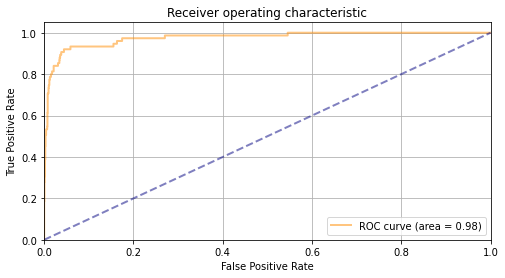

In [298]:
curve = ROC_Curve(X_test, y_test, [], tunned_model)

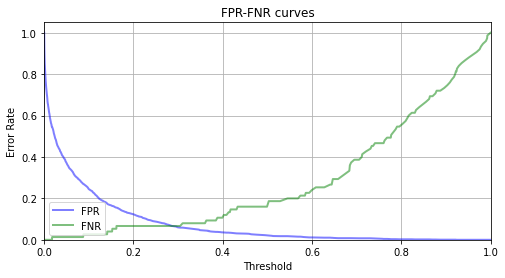

In [299]:
FPR_FNR_Curve(curve)

#### Возьмем threshold = 0.8

In [339]:
final_metrics = pd.DataFrame(columns = ['Threshold','Precision', 'Recall', 'AUC', 'F1', 'Accuracy'])
for threshold in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:
    result_df = pd.DataFrame()
    result_df['outputs'] = list(tunned_model.predict_proba(X_test)[:,1:])
    result_df['outputs'] = result_df['outputs'].astype(float)
    def rescale(x):
        if x < threshold:
            return 0
        else:
            return 1
    result_df.outputs = result_df.outputs.map(rescale)
    final_metrics = final_metrics.append({'Threshold':threshold,\
                                          'Precision':precision_score(result_df.outputs, y_test),\
                                          'Recall':recall_score(result_df.outputs, y_test),\
                                          'AUC':roc_auc_score(result_df.outputs, y_test),\
                                          'F1':f1_score(result_df.outputs, y_test),\
                                          'Accuracy':accuracy_score(result_df.outputs, y_test)},\
                                         ignore_index=True)

In [343]:
final_metrics.sort_values(['Accuracy', 'F1'], ascending=False)

,Threshold,Precision,Recall,AUC,F1,Accuracy
3,0.65,0.706667,0.791045,0.888888,0.746479,0.979130
2,0.60,0.760000,0.750000,0.869542,0.754967,0.978551
4,0.70,0.613333,0.793103,0.887853,0.691729,0.976232
1,0.55,0.800000,0.681818,0.836328,0.736196,0.975072
5,0.75,0.533333,0.816327,0.897722,0.645161,0.974493
6,0.80,0.440000,0.891892,0.933505,0.589286,0.973333
0,0.50,0.840000,0.642857,0.817741,0.728324,0.972754
7,0.85,0.333333,0.892857,0.931697,0.485437,0.969275
8,0.90,0.253333,0.950000,0.958578,0.400000,0.966957


### Вывод: Как видно из таблицы, граница = 0.65 обладает наилучшей комбинацией метрик
#### И Precision и Recall на оптимальном среди всех остальных наблюдей уровне

#### Можно еще ради интереса посмотреть на метрики, убрав в тесте дисбаланс классов

In [430]:
test_no_disb_df = X_test
test_no_disb_df['default_12m'] = y_test
test_no_disb_df = pd.concat([test_no_disb_df[test_no_disb_df.default_12m == 1],\
                            test_no_disb_df[test_no_disb_df.default_12m == 0]\
                             .head(test_no_disb_df[test_no_disb_df.default_12m == 1].shape[0])])

In [431]:
result_df = pd.DataFrame()
result_df['outputs'] = list(tunned_model.predict_proba(test_no_disb_df.drop('default_12m', axis = 1))[:,1:])
result_df['outputs'] = result_df['outputs'].astype(float)
result_df['true_vals'] = list(test_no_disb_df.default_12m)
def rescale(x):
        if x < 0.65:
            return 0
        else:
            return 1
result_df.outputs = result_df.outputs.map(rescale)

#### Неплохие результаты. Мы нашли 96% класса 1 (а ошибаться в нем нам крайне нежелательно, учитывая семантику предметной области). И 70% классифицированных нами как объекты класса 1 - действительно являются классом 1
#### Точность, при отношении классов 1:1 составила 84%

In [432]:
print('Precision',precision_score(result_df.outputs, result_df.true_vals))
print('Recall',recall_score(result_df.outputs, result_df.true_vals))
print('AUC',roc_auc_score(result_df.outputs, result_df.true_vals))
print('F1',f1_score(result_df.outputs, result_df.true_vals))
print('Accuracy',accuracy_score(result_df.outputs, result_df.true_vals))

Precision 0.7066666666666667
Recall 0.9636363636363636
AUC 0.8660287081339713
F1 0.8153846153846154
Accuracy 0.84


## Формируем файл с ответом [система почему-то не принемает ответы:(     ]

In [377]:
answ_df = test_df[['record_id']]
answ_df['id'] = answ_df['record_id']
answ_df.drop('record_id',axis=1, inplace=True)

/var/folders/_z/z5my6rgn7kq2z6xjsdk61qsr0000gn/T/ipykernel_3194/1713649605.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answ_df['id'] = answ_df['record_id']
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [378]:
test_df['ul_staff_range'] = test_df['ul_staff_range'].map(dict_for_ul_staff_range)

In [379]:
result_df = pd.DataFrame()
result_df['outputs'] = list(tunned_model.predict_proba(test_df)[:,1:])
result_df['outputs'] = result_df['outputs'].astype(float)
def rescale(x):
        if x < threshold:
            return 0
        else:
            return 1
result_df.outputs = result_df.outputs.map(rescale)

In [386]:
answ_df['predict'] = result_df.outputs


/var/folders/_z/z5my6rgn7kq2z6xjsdk61qsr0000gn/T/ipykernel_3194/274947641.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answ_df['predict'] = result_df.outputs


In [391]:
answ_df

,id,predict
0,196,0
1,1196,0
2,2813,0
3,4385,0
4,6479,0
...,...,...
195,265577,0
196,266648,0
197,266849,0
198,267566,0


In [389]:
answ_df.to_csv('/Users/artemarhipov/Downloads/PD-submit.csv',index=False, sep=';')

#### К сожалению, платформа не принимает сабмиты(((((